<a href="https://colab.research.google.com/github/PYFTS/notebooks/blob/master/Ismail%20%26%20Efendi%20-%20ImprovedWeightedFTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Order Improved Weighted Fuzzy Time Series by Efendi, Ismail and Deris (2013)

R. Efendi, Z. Ismail, and M. M. Deris, “Improved weight Fuzzy Time Series as used in the exchange rates forecasting of 
US Dollar to Ringgit Malaysia,” Int. J. Comput. Intell. Appl., vol. 12, no. 1, p. 1350005, 2013.

## Environment Setup

### Library install/update

In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-sm6te7pr
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-sm6te7pr
  Created wheel for pyFTS: filename=pyFTS-1.6-cp36-none-any.whl size=197025 sha256=fa5975e048b6fe90453ed5024a17dc0ef34718f6b2af888e6c4c0f03b27c8db9
  Stored in directory: /tmp/pip-ephem-wheel-cache-xmnwubyw/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS


### External libraries import

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Common pyFTS imports 

In [0]:
from pyFTS.common import Util as cUtil
from pyFTS.benchmarks import benchmarks as bchmk, Util as bUtil
from pyFTS.partitioners import Util as pUtil

from pyFTS.models import ismailefendi


## Common data transformations

In [0]:
from pyFTS.common import Transformations

tdiff = Transformations.Differential(1)

boxcox = Transformations.BoxCox(0)

## Datasets

### Data Loading

In [0]:
from pyFTS.data import TAIEX, NASDAQ, SP500

dataset_names = ["TAIEX", "SP500","NASDAQ"]

def get_dataset(name):
    if dataset_name == "TAIEX":
        return TAIEX.get_data()
    elif dataset_name == "SP500":
        return SP500.get_data()[11500:16000]
    elif dataset_name == "NASDAQ":
        return NASDAQ.get_data()


train_split = 2000
test_length = 200

### Visualization

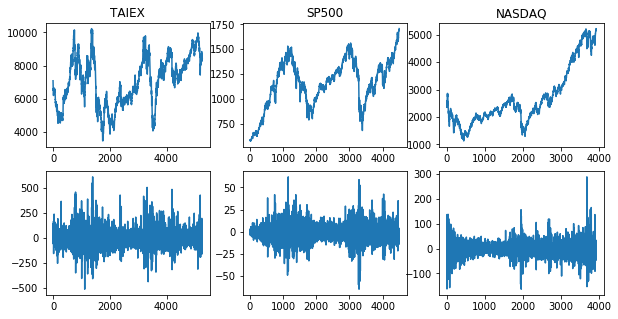

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[10,5])

for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)
    dataset_diff = tdiff.apply(dataset)

    ax[0][count].plot(dataset)
    ax[1][count].plot(dataset_diff)
    ax[0][count].set_title(dataset_name)

### Statistics

In [0]:
from statsmodels.tsa.stattools import adfuller

rows =[]

for count,dataset_name in enumerate(dataset_names):
    row = [dataset_name]
    dataset = get_dataset(dataset_name)
    result = adfuller(dataset)
    row.extend([result[0],result[1]])
    row.extend([value for key, value in result[4].items()])
    rows.append(row)
    
pd.DataFrame(rows,columns=['Dataset','ADF Statistic','p-value','Cr. Val. 1%','Cr. Val. 5%','Cr. Val. 10%'])


,Dataset,ADF Statistic,p-value,Cr. Val. 1%,Cr. Val. 5%,Cr. Val. 10%
0,TAIEX,-2.656728,0.081830,-3.431601,-2.862093,-2.567064
1,SP500,-1.747171,0.406987,-3.431811,-2.862186,-2.567114
2,NASDAQ,0.476224,0.984132,-3.432022,-2.862279,-2.567163


## Partitioning

The best number of partitions of the Universe of Discourse is an optimization problem. The know more about partitioning schemes please look on the Partitioners notebook. To know more about benchmarking look on the Benchmarks notebook.

In [0]:
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.benchmarks import benchmarks as bchmk
from pyFTS.models import chen

tag = 'chen_partitioning'
_type = 'point'

for dataset_name in dataset_names:
    dataset = get_dataset(dataset_name)

    bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                    methods=[chen.ConventionalFTS],
                                    benchmark_models=False,
                                    transformations=[None],
                                    partitions=np.arange(10,100,2), 
                                    progress=False, type=_type,
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)

    bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                    methods=[chen.ConventionalFTS],
                                    benchmark_models=False,
                                    transformations=[tdiff],
                                    partitions=np.arange(3,30,1), 
                                    progress=False, type=_type,
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)


In [0]:
from pyFTS.benchmarks import Util as bUtil

df1 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'chen_partitioning' and measure = 'rmse'and transformation is null")

df2 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                  "tag = 'chen_partitioning' and measure = 'rmse' and transformation is not null")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,7])

g1 = sns.boxplot(x='Partitions', y='Value', hue='Dataset', data=df1, showfliers=False, ax=ax[0], 
                 palette="Set3")
box = g1.get_position()
g1.set_position([box.x0, box.y0, box.width * 0.85, box.height]) 
g1.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1)
ax[0].set_title("Original data")
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("")

g2 = sns.boxplot(x='Partitions', y='Value', hue='Dataset', data=df2, showfliers=False, ax=ax[1], 
                 palette="Set3")
box = g2.get_position()
g2.set_position([box.x0, box.y0, box.width * 0.85, box.height]) 
g2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1)
ax[1].set_title("Differentiated data")
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Number of partitions of the UoD")

### Comparing the partitioning schemas

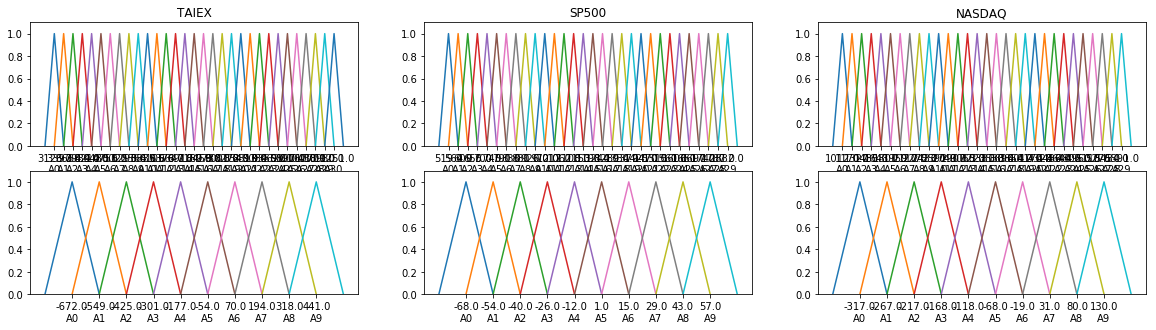

In [6]:
from pyFTS.partitioners import Grid, Util as pUtil

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,5])


partitioners = {}
partitioners_diff = {}

for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)

    partitioner = Grid.GridPartitioner(data=dataset, npart=30)
    partitioners[dataset_name] = partitioner
    partitioner_diff = Grid.GridPartitioner(data=dataset, npart=10, transformation=tdiff)
    partitioners_diff[dataset_name] = partitioner_diff

    pUtil.plot_sets(dataset, [partitioner.sets], titles=[dataset_name], axis=ax[0][count])
    pUtil.plot_sets(dataset, [partitioner_diff.sets], titles=[''], axis=ax[1][count])

## Fitting models

### With original data

In [7]:
for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)

    model1 = ismailefendi.ImprovedWeightedFTS(partitioner=partitioners[dataset_name])
    model1.name=dataset_name
    model1.fit(dataset[:train_split], save_model=True, file_path='model1'+dataset_name, order=1)

    print(model1)

TAIEX:
A1 -> A1(0.2),A2(0.8)
A2 -> A1(0.308),A2(0.462),A3(0.231)
A3 -> A2(0.176),A3(0.706),A4(0.118)
A4 -> A3(0.095),A4(0.762),A5(0.143)
A5 -> A4(0.063),A5(0.794),A6(0.143)
A6 -> A5(0.081),A6(0.831),A7(0.089)
A7 -> A6(0.074),A7(0.832),A8(0.094)
A8 -> A6(0.01),A7(0.146),A8(0.688),A9(0.156)
A9 -> A10(0.164),A8(0.131),A9(0.705)
A10 -> A10(0.707),A11(0.114),A12(0.008),A9(0.171)
A11 -> A10(0.129),A11(0.782),A12(0.089)
A12 -> A11(0.091),A12(0.818),A13(0.091)
A13 -> A12(0.141),A13(0.798),A14(0.061)
A14 -> A13(0.07),A14(0.86),A15(0.07)
A15 -> A14(0.114),A15(0.743),A16(0.143)
A16 -> A15(0.113),A16(0.6),A17(0.275),A18(0.013)
A17 -> A15(0.008),A16(0.165),A17(0.685),A18(0.142)
A18 -> A16(0.009),A17(0.154),A18(0.684),A19(0.154)
A19 -> A18(0.176),A19(0.686),A20(0.137)
A20 -> A19(0.175),A20(0.688),A21(0.125),A22(0.013)
A21 -> A20(0.18),A21(0.639),A22(0.164),A23(0.016)
A22 -> A21(0.175),A22(0.714),A23(0.111)
A23 -> A22(0.207),A23(0.655),A24(0.138)
A24 -> A21(0.033),A22(0.033),A23(0.067),A24(0.7),A25(0

### With transformed data

In [8]:
for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)

    model2 = ismailefendi.ImprovedWeightedFTS(partitioner=partitioners_diff[dataset_name])
    model2.name=dataset_name
    model2.append_transformation(tdiff)
    model2.fit(dataset[:train_split], save_model=True, file_path='model2'+dataset_name, order=1)

    print(model2)

TAIEX:
A1 -> A3(1.0)
A4 -> A0(0.006),A2(0.018),A3(0.018),A4(0.151),A5(0.47),A6(0.295),A7(0.042)
A6 -> A1(0.001),A2(0.003),A3(0.006),A4(0.057),A5(0.402),A6(0.471),A7(0.054),A8(0.003),A9(0.003)
A3 -> A3(0.13),A4(0.174),A5(0.391),A6(0.174),A7(0.13)
A5 -> A2(0.003),A3(0.011),A4(0.1),A5(0.502),A6(0.326),A7(0.053),A8(0.003),A9(0.001)
A7 -> A3(0.008),A4(0.024),A5(0.299),A6(0.465),A7(0.189),A8(0.016)
A9 -> A5(0.25),A6(0.75)
A2 -> A4(0.125),A5(0.375),A7(0.375),A8(0.125)
A8 -> A5(0.273),A6(0.364),A7(0.091),A8(0.273)
A0 -> A9(1.0)

SP500:
A2 -> A3(0.4),A4(0.6)
A3 -> A0(0.017),A2(0.017),A3(0.233),A4(0.267),A5(0.25),A6(0.167),A7(0.05)
A0 -> A4(1.0)
A5 -> A2(0.001),A3(0.005),A4(0.186),A5(0.683),A6(0.114),A7(0.01),A8(0.001)
A4 -> A2(0.007),A3(0.084),A4(0.379),A5(0.451),A6(0.067),A7(0.009),A8(0.002)
A6 -> A3(0.003),A4(0.09),A5(0.517),A6(0.351),A7(0.038)
A7 -> A3(0.028),A4(0.056),A5(0.389),A6(0.361),A7(0.167)
A8 -> A5(0.333),A6(0.333),A8(0.333)

NASDAQ:
A6 -> A3(0.001),A4(0.004),A5(0.038),A6(0.61),A7(0

## Predicting with the models

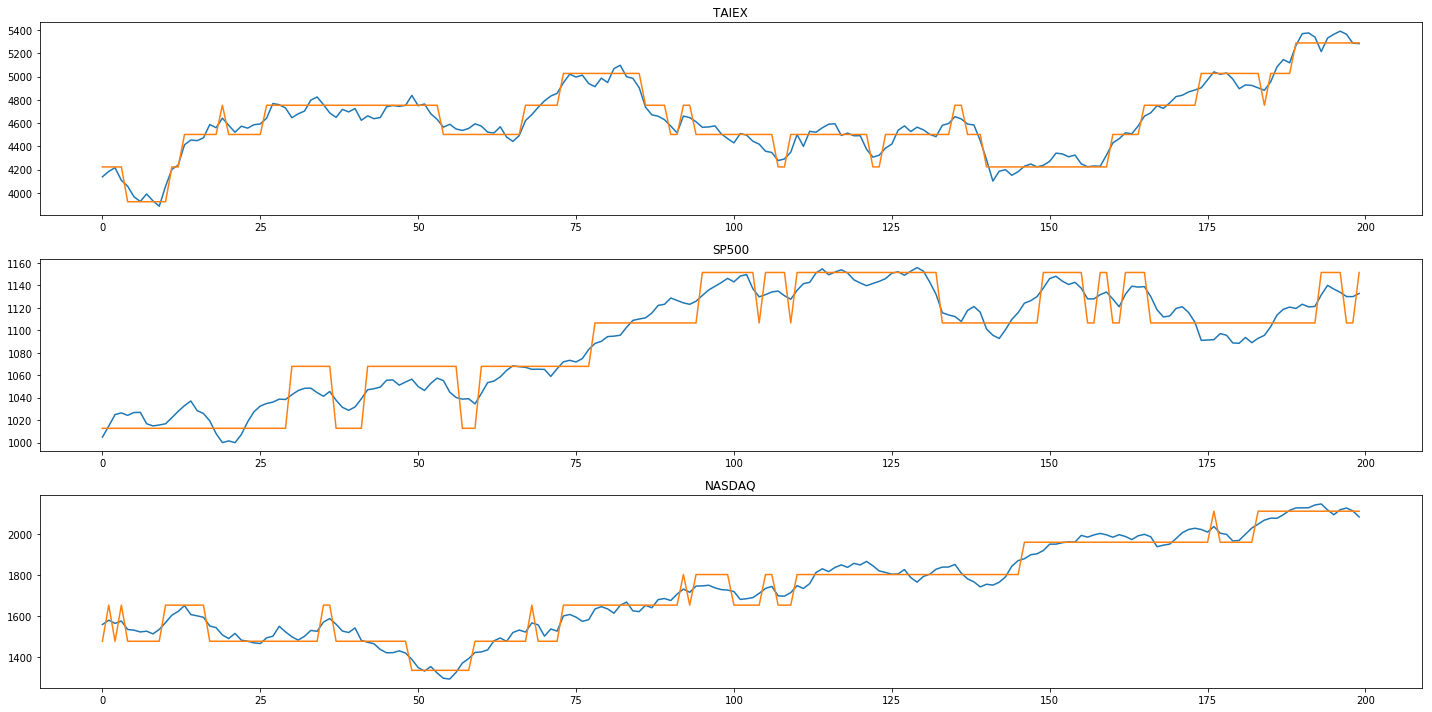

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[20,10])


for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)
    
    ax[count].plot(dataset[train_split:train_split+200])

    model1 = cUtil.load_obj('model1'+dataset_name)

    forecasts = model1.predict(dataset[train_split:train_split+200])
    
    ax[count].plot(forecasts)
    
    ax[count].set_title(dataset_name)
    
plt.tight_layout()

In [10]:
from pyFTS.benchmarks import Measures

rows = []

for count,dataset_name in enumerate(dataset_names):
    row = [dataset_name]
    
    dataset = get_dataset(dataset_name)
    
    test = dataset[train_split:train_split+200]

    model1 = cUtil.load_obj('model1'+dataset_name)
    
    row.extend(Measures.get_point_statistics(test, model1))
    
    rows.append(row)
    
    
pd.DataFrame(rows,columns=["Dataset","RMSE","SMAPE","Theil's U"])
    
    
    

,Dataset,RMSE,SMAPE,Theil's U
0,TAIEX,93.22,1.59,1.42
1,SP500,15.57,1.22,2.80
2,NASDAQ,49.38,2.42,2.06


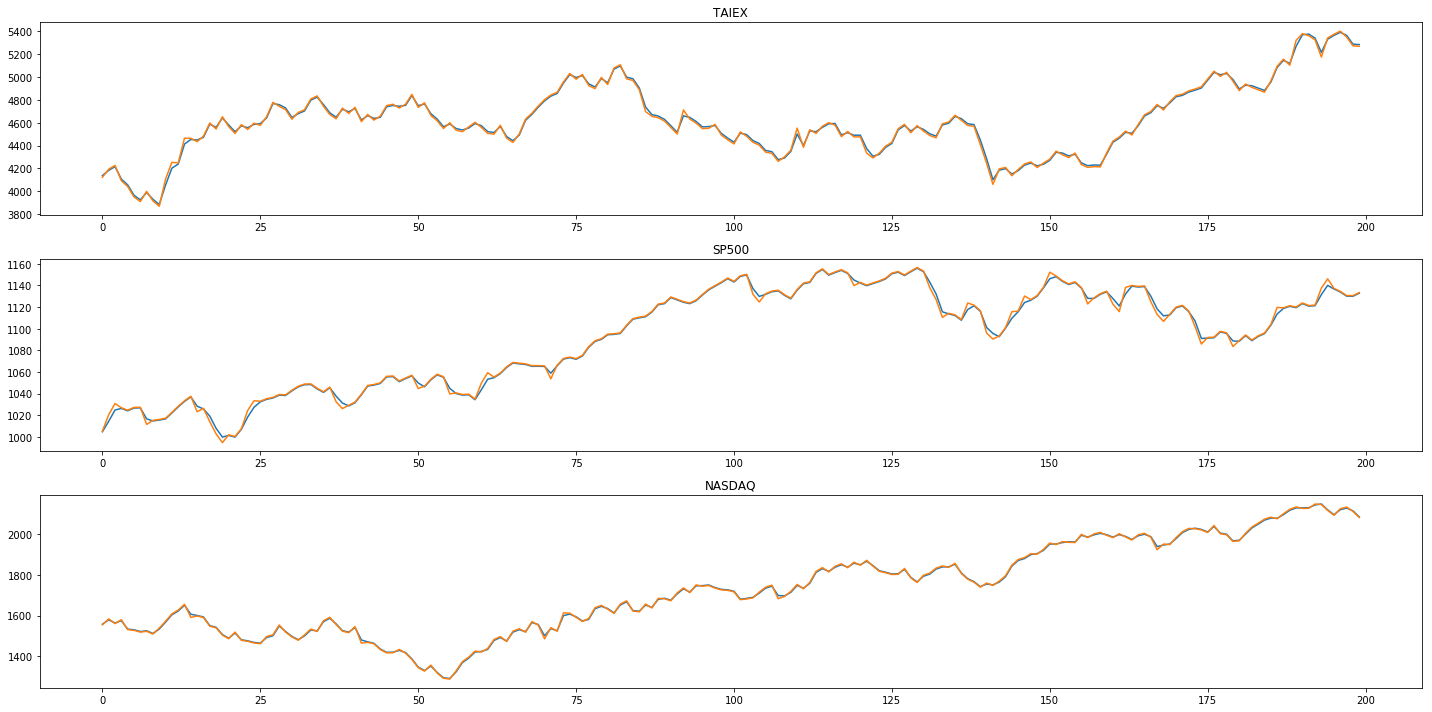

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[20,10])


for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)
    
    ax[count].plot(dataset[train_split:train_split+200])

    model1 = cUtil.load_obj('model2'+dataset_name)

    forecasts = model1.predict(dataset[train_split:train_split+200])
    
    ax[count].plot(forecasts)
    
    ax[count].set_title(dataset_name)
    
plt.tight_layout()

In [12]:
from pyFTS.benchmarks import Measures

rows = []

for count,dataset_name in enumerate(dataset_names):
    row = [dataset_name]
    
    dataset = get_dataset(dataset_name)
    
    test = dataset[train_split:train_split+200]

    model1 = cUtil.load_obj('model2'+dataset_name)
    
    row.extend(Measures.get_point_statistics(test, model1))
    
    rows.append(row)
    
    
pd.DataFrame(rows,columns=["Dataset","RMSE","SMAPE","Theil's U"])
    
    
    

,Dataset,RMSE,SMAPE,Theil's U
0,TAIEX,64.89,1.11,0.99
1,SP500,5.17,0.38,0.94
2,NASDAQ,24.20,1.16,1.01


## Residual Analysis

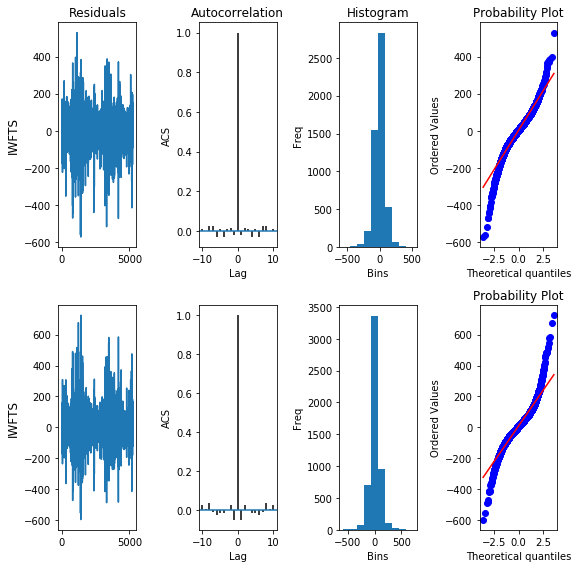

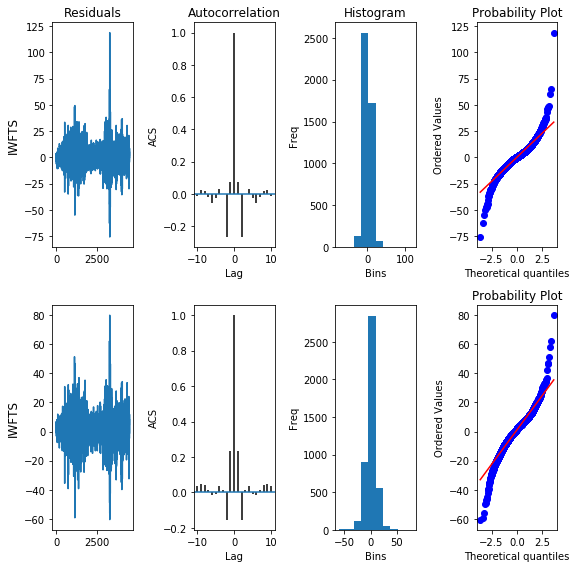

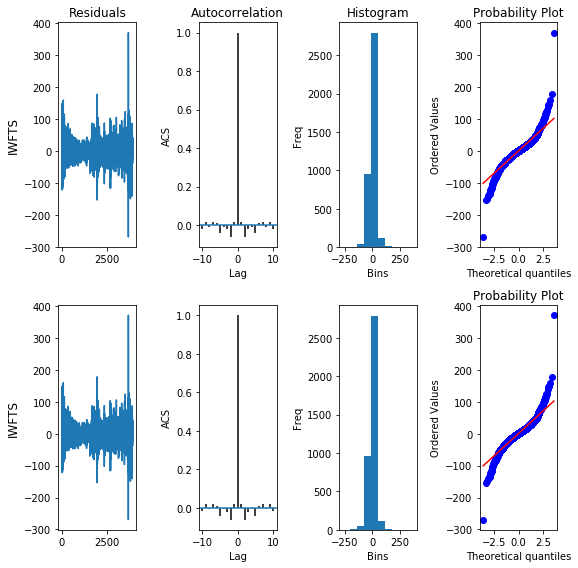

In [14]:
from pyFTS.benchmarks import ResidualAnalysis as ra

for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)
    
    model1 = cUtil.load_obj('model1'+dataset_name)
    model1 = cUtil.load_obj('model2'+dataset_name)

    ra.plot_residuals_by_model(dataset, [model1, model2])